In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

/Users/akshikarohtagi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,201 (4.69 KB)

 Trainable params: 1,201 (4.69 KB)

 Non-trainable params: 0 (0.00 B)

Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 188s 38ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


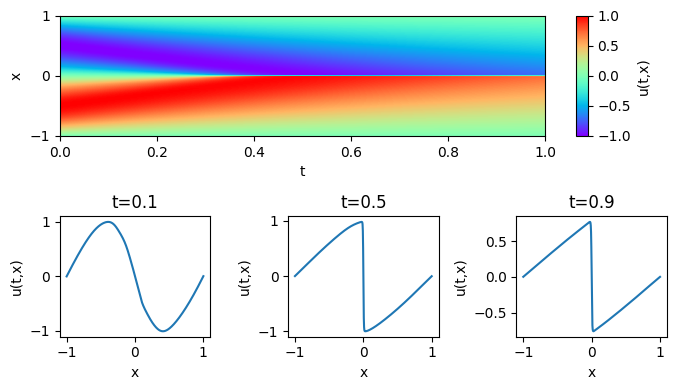

In [22]:
# number of training samples
num_train_samples = 10000
# number of test samples
num_test_samples = 1000
# kinematic viscosity
nu = 0.01 / np.pi

# build a core network model
network = Network.build()
network.summary()
# build a PINN model
pinn = PINN(network, nu).build()

# create training input
tx_eqn = np.random.rand(num_train_samples, 2)          # t_eqn =  0 ~ +1
tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1                # x_eqn = -1 ~ +1
tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
tx_ini[..., 0] = 0                                     # t_ini =  0
tx_bnd = np.random.rand(num_train_samples, 2)          # t_bnd =  0 ~ +1
tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1      # x_bnd = -1 or +1
# create training output
u_eqn = np.zeros((num_train_samples, 1))               # u_eqn = 0
u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

# train the model using L-BFGS-B algorithm
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [ u_eqn,  u_ini,  u_bnd]
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

# predict u(t,x) distribution
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.10, 0.5, 0.90]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()
# plot u(t=const, x) cross-sections
# t_cross_sections = [0.10, 0.90]
# for i, t_cs in enumerate(t_cross_sections):
#     plt.subplot(gs[1, i])
#     tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
#     u = network.predict(tx, batch_size=num_test_samples)
#     plt.plot(x_flat, u)
#     plt.title('t={}'.format(t_cs))
#     plt.xlabel('x')
#     plt.ylabel('u(t,x)')
# plt.tight_layout()
# plt.show()



In [32]:
import scipy.io

data = scipy.io.loadmat('burgers_shock.mat')
    

t = data['t'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
Exact = np.real(data['usol']).T # T x N

idx_t0 = 10
idx_t1 = 50
idx_t2 = 90

dt = t[idx_t1] - t[idx_t0]
  
N = 250
# Initial data
noise_u0 = 0.0
idx_x = np.random.choice(Exact.shape[1], N, replace=False) 
x0 = x[idx_x,:]
u0 = Exact[idx_t0:idx_t0+1,idx_x].T
u0 = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

q = 500
layers = [1, 50, 50, 50, q+1]
lb = np.array([-1.0])
ub = np.array([1.0])
# Boudanry data
x1 = np.vstack((lb,ub))

# Test data
x_star = x

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


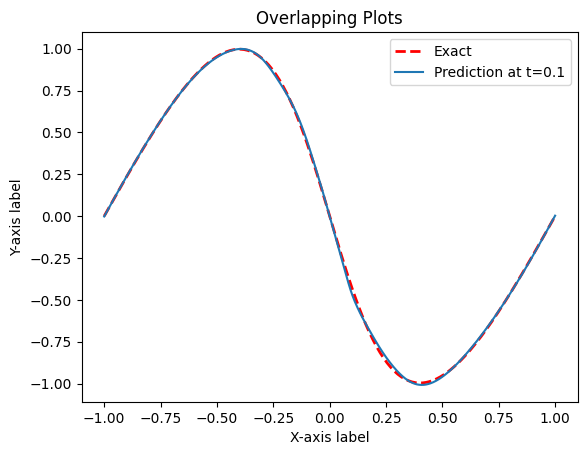

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the exact values
ax.plot(x, Exact[idx_t0, :],'r--', linewidth=2, label='Exact')

t_cross_sections = [0.10]


for i, t_cs in enumerate(t_cross_sections):
    # Prepare data for the prediction
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    
    # Plot the prediction on the same axes
    ax.plot(x_flat, u, label='Prediction at t={}'.format(t_cs))

# Optionally, set labels and title
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Overlapping Plots')

# Display the legend
ax.legend()

# Show the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


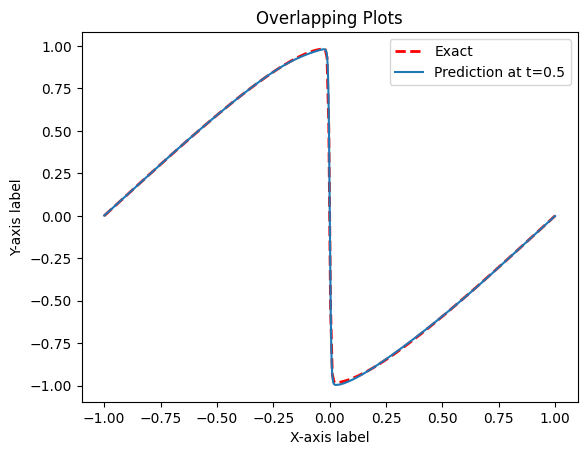

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the exact values
ax.plot(x, Exact[idx_t1, :], 'r--',  linewidth=2, label='Exact')

t_cross_sections = [0.5]


for i, t_cs in enumerate(t_cross_sections):
    # Prepare data for the prediction
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    
    # Plot the prediction on the same axes
    ax.plot(x_flat, u, label='Prediction at t={}'.format(t_cs))

# Optionally, set labels and title
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Overlapping Plots')

# Display the legend
ax.legend()

# Show the plot
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


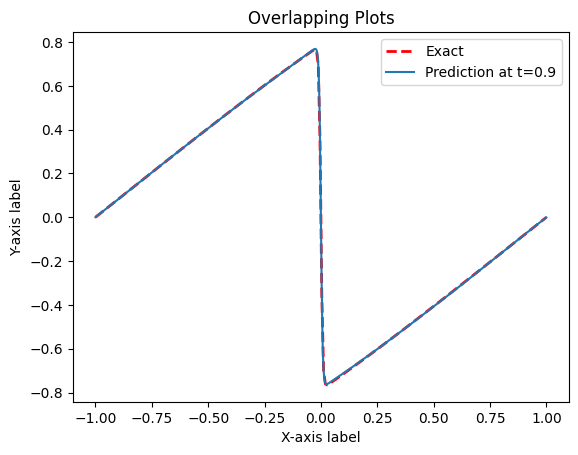

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and an axes object
fig, ax = plt.subplots()

# Plot the exact values
ax.plot(x, Exact[idx_t2, :],'r--', linewidth=2, label='Exact')

t_cross_sections = [0.9]


for i, t_cs in enumerate(t_cross_sections):
    # Prepare data for the prediction
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    
    # Plot the prediction on the same axes
    ax.plot(x_flat, u, label='Prediction at t={}'.format(t_cs))

# Optionally, set labels and title
ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Overlapping Plots')

# Display the legend
ax.legend()

# Show the plot
plt.show()
